Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность $p_+$ отнесения примера $\vec{x_i}$ к классу "+":
$$p_+ = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) $$

Прогнозирование не просто ответа ("+1" или "-1"), а именно *вероятности* отнесения к классу "+1" во многих задачах является очень важным бизнес-требованием. Например, в задаче кредитного скоринга, где традиционно применяется логистическая регрессия, часто прогнозируют вероятность невозврата кредита ($p_+$). Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — по сути, рейтинг клиентов от плохих к хорошим. Ниже приведен игрушечный пример такой скоркарты. 
    <img src='./img/toy_scorecard.png' width=60%>

Банк выбирает для себя порог $p_*$ предсказанной вероятности невозврата кредита (на картинке – $0.15$) и начиная с этого значения уже не выдает кредит.

Итак, мы хотим прогнозировать вероятность $p_+ \in [0,1]$, а пока умеем строить линейный прогноз с помощью МНК: $b(\vec{x}) = \vec{w}^T \vec{x} \in \mathbb{R}$. Каким образом преобразовать полученное значение в вероятность, пределы которой – [0, 1]? Очевидно, для этого нужна некоторая функция $f: \mathbb{R} \rightarrow [0,1].$ В модели логистической регрессии для этого берется конкретная функция: $\sigma(z) = \frac{1}{1 + \exp^{-z}}$.  

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def sigma(z):
    return 1. / (1 + np.exp(-z))

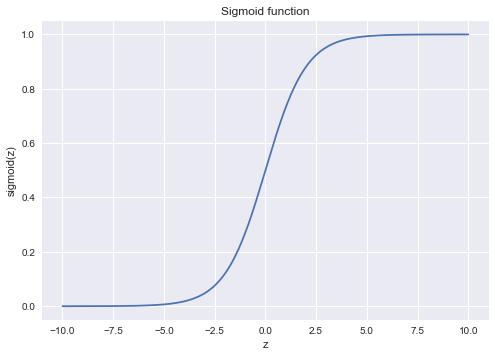

In [3]:
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, [sigma(x) for x in xx]);
plt.xlabel('z');
plt.ylabel('sigmoid(z)')
plt.title('Sigmoid function');

Итак, логистическая регрессия прогнозирует вероятность отнесения примера к классу "+" (при условии, что мы знаем его признаки и веса модели) как сигмоид-преобразование линейной комбинации вектора весов модели и вектора признаков примера:

$$p_+(x_i) = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) = \sigma(\vec{w}^T\vec{x_i}). $$

В даном случае принцип максимизации правдоподобия приводит к минимизации выражения(пускай результаты классификации -1 и 1) 
$$z = \vec{w}^T\vec{x_i}$$
Логарифм потерь:
$$\mathcal{L_{log}} (X, \vec{y}, \vec{w}) = \sum_{i=1}^{\ell} {y_i}\log(\sigma({z})) + ({1 - y_i})\log(1 - \sigma({z}))).$$

Если обозначить y = 0 за -1, то путём преобразований получим
$$\mathcal{L_{log}} (X, \vec{y}, \vec{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}}).$$

Это *логистическая* функция потерь, просуммированная по всем объектам обучающей выборки.


### Регуляризация

Вместо исходного функционала потерь будем минимизировать следующий:

$$J(X, \vec{y}, \vec{w}) = \mathcal{L_{log}} (X, \vec{y}, \vec{w}) + \lambda |\vec{w}|^2$$

В случае логистической регрессии принято введение обратного коэффициента регуляризации $C = \frac{1}{\lambda}$. И тогда решением задачи будет

$$\hat{w}  = \arg \min_{\vec{w}} J(X, \vec{y}, \vec{w}) =  \arg \min_{\vec{w}}\ (C\sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})+ |\vec{w}|^2)$$ 

Далее рассмотрим пример, позволяющий интуитивно понять один из смыслов регуляризации. 

In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [5]:
# загрузка данных
data = pd.read_csv('../../data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [6]:
X = data.ix[:,:2].values
y = data.ix[:,2].values

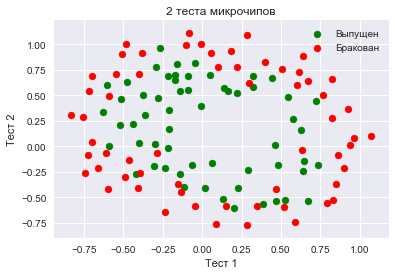

In [7]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов')
plt.legend();

In [8]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Полиномиальными признаками до степени $d$ для двух переменных $x_1$ и $x_2$ мы называем следующие:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

Например, для $d=3$ это будут следующие признаки:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Нарисовав треугольник Пифагора, Вы сообразите, сколько таких признаков будет для $d=4,5...$ и вообще для любого $d$.
Попросту говоря, таких признаков экспоненциально много, и строить, скажем, для 100 признаков полиномиальные степени 10 может оказаться затратно (а более того, и не нужно). 


In [9]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [10]:
print(X.shape)
print(X_poly.shape)

(118, 2)
(118, 36)


In [11]:
?LogisticRegression()

Доля правильных ответов классификатора на обучающей выборке: 0.627


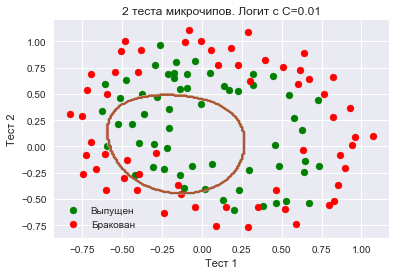

In [12]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Увеличим $C$ до 1. Тем самым мы *ослабляем* регуляризацию, теперь в решении значния весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае. 

Доля правильных ответов классификатора на обучающей выборке: 0.831


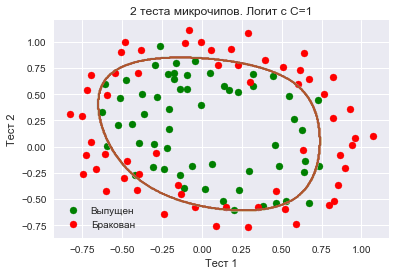

In [13]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=1')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.873


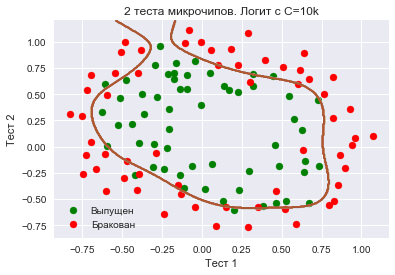

In [14]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=10k')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Чтоб обсудить результаты, перепишем формулу для функционала, который оптимизируется в логистической регрессии, в таком виде:
$$J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

где
 - $\mathcal{L}$ – логистическая функция потерь, просуммированная по всей выборке
 - $C$ – обратный коэффициент регуляризации (тот самый $C$ в `sklearn`-реализации `LogisticRegression`)

**Выводы**:
 - чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity))
 - если регуляризация слишком сильная (малые значения $C$), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки (то есть в функционале $J$ "перевешивает" сумма квадратов весов, а ошибка $\mathcal{L}$ может быть относительно большой). В таком случае модель окажется *недообученной* (1 случай)
 - наоборот, если регуляризация слишком слабая (большие значения $C$), то решением задачи оптимизации может стать вектор $w$ с большими по модулю  компонентами. В таком случае больший вклад в оптимизируемый функционал $J$ имеет  $\mathcal{L}$ и, вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется *переобученной* (3 случай)
 - то, какое значение $C$ выбрать, сама логистическая регрессия "не поймет" (или еще говорят "не выучит"), то есть это не может быть определено решением оптимизационной задачи, которой является логистическая регрессия (в отличие от весов $w$). Так же точно, дерево решений не может "само понять", какое ограничение на глубину выбрать (за один процесс обучения). Поэтому $C$ – это *гиперпараметр* модели, который настраивается на кросс-валидации(как и например *max_depth* для дерева).

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


LogisticRegressionCV(Cs=array([  1.00000e-02,   1.02334e-02, ...,   9.77192e+02,   1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [16]:
logit_searcher.C_

array([ 198.8827857])

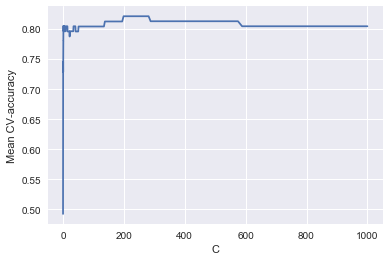

In [17]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');